### IMPORT LIBRARIES

In [2]:
%matplotlib inline

import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import math
from copy import deepcopy
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import geopy.distance
from scipy import stats
from scipy.integrate import quad
import seaborn as sns
import random
import elevation
import os
import json
import imageio
import pdb
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh


# climada libraries
from climada.hazard import TCTracks
from climada.hazard import TropCyclone, Centroids

2023-02-22 10:59:10,016 - climada.hazard.tc_tracks - WARNING - 104 storm events are discarded because no valid wind/pressure values have been found: 1922284N12285, 1922285N17276, 1924170N18275, 1924286N26272, 1925249N22267, ...
2023-02-22 10:59:10,024 - climada.hazard.tc_tracks - WARNING - 28 storm events are discarded because only one valid timestep has been found: 1922164N15278, 1923174N20265, 1925331N20274, 1930241N13317, 1931192N16278, ...
Number of tracks: 327


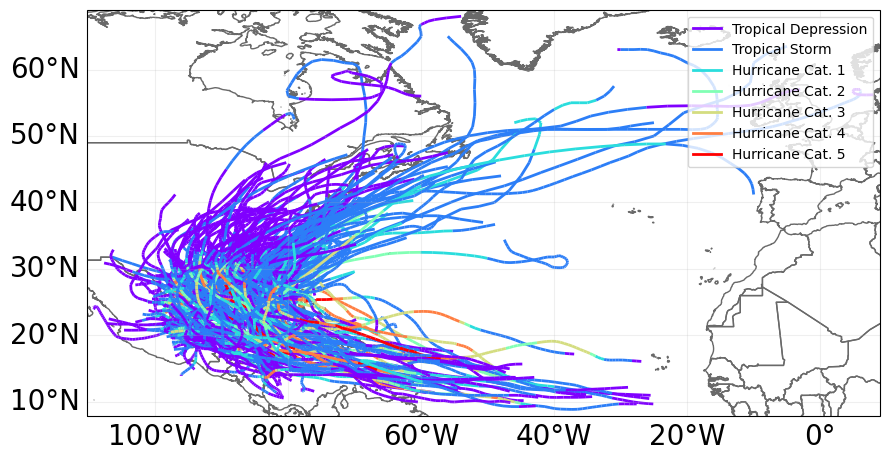

In [4]:
storm_track = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(1922, 2022), subbasin='GM', correct_pres=False)

print('Number of tracks:', storm_track.size)

# sel_ibtracs.data[0].to_dataframe()
storm_track.plot();
# ax.get_legend()._loc = 2 # correct legend location
# ax.set_title('1993-1994, EP') # set title

In [ ]:
hurricane_dataframe = storm_track.data[0].to_dataframe()
len(sel_ibtracs.data)

sel_ibtracs.data

### HURRICANE ANALYSIS AND TRACK GENERATION FROM CLIMADA ###

In [5]:
######################################## data for the entire simulation #######################################################

# STORM DATA
storm_ID = "2017228N14314"    # id of the storm from iBtracks -> this is the id for hurricane Harvey
years_range =  (1922, 2022)   # range of years from which the hurricane data is required
subbasin = 'GM'               # can provide basin or sub-basin. Here, 'GM' refers to the gulf of mexico
time_report = 2               # set the hours of time stamps i.e. data is provided for every "time_report" hours
provider='usa'                # set the data provider "usa" for default

# WINDFIELD GENERATION FROM CLIMADA
min_lat, max_lat, min_lon, max_lon = 25, 37, -108, -92.5 # define min and max lat/lon for the centroids raster of climada
centroid_resolution = 0.05                               # define resolution for centroids (Hint: lower the better but takes more computation)
intensity_thres = 0                                      # define threshold to compute intensities (eg. 10 means windspeed < 10 is considered as 0)
store_windfields = False                                 # boolean value that determines if one needs to save windfield vector (returns csr sparse matrix) and can be accessed by "windfields" method 

# FILES FOR THE POWER SYSTEMS MODEL
bus_data_filename = 'Texas2000busdata-BUS.txt'
line_data_filename = 'Texas2000busdata-LINES.txt'
substation_data_filename = 'Texas2000busdata-SUBSTATION_2.txt'

# PARAMETERS FOR THE HURRICANE
# please refer to our first paper on hurricane on how these parameters are selected/identified
B = 10                                                   # beta value that tells the reduction of hurricane windspeed at the end of its radius
K = 1.14                                                 # a constant parameter in the hurricane windfield piecewise function 
α = 0.04                                                 # land decay parameter for Texas 
wind_lower_bound = 48.59                                 # lower bound of the windspeed (in knots) below which Transmission Lines is unaffected
wind_upper_bound = 106.91                                # upper bound of the windspeed (in knots) above which Transmission Lines is damaged
savefig_windfield = False                                # boolean value that decides whether you want to save figure or not (Default: False)
earth_radius_unit = "nautical_miles"                     # unit of distance for the radius of the earth

# FIGURE PARAMETERS FOR THE WINDFIELD
extent = [-107.5, -92.5, 25.0, 37.0]                     # extent of the figure in [lon1, lon2, lat1, lat2] format
grid_resolution = 0.01                                   # grid resolution
mesh_lon = np.arange(-107.5, -92.5, grid_resolution)     # meshgrid for longitude  
mesh_lat = np.arange(25.0, 37.0, grid_resolution)        # meshgrid for latitude         
mesh_lon, mesh_lat = np.meshgrid(mesh_lon, mesh_lat)     # meshgrid in lon,lat format
color_map = "OrRd"                                       # color map for the hurricane windfield (Default: "OrRd" i.e. Orange Red)

# Flood scenarios
flood_basins = ["meow_NW_matagorda", "meow_NW_laguna",   # 5 different Texas basins from SLOSH model (Cat4 -- NW -- 10mph) these are separately obtained from SLOSH Display program
                "meow_NW_corpus", "meow_NW_galveston", 
                "meow_NW_sabine"]
flood_substation_resolution = 0.5                        # resolution (in miles) to analyze the depth level of flood to substation (accuracy of location within x.x miles)
weibull_exp_a = 13                                       # parameter a for weibull exponential function (arbritarily selected: needs more work)
weibull_exp_b = 3                                        # parameter b for weibull exponential function (required: b > 2 and odd; arbritarily selected: needs more work)
substation_elevation_height = 3                          # assuming substations are pre-elevated (in ft: assuming these are coastal regions and substations are proactively elevated by the operators at certain height)
 

In [5]:
# instantiate tropical cyclone tracks class from Climada
generate_storm = TCTracks()

# based on the provider. and storm argument the track for the storm is obtained from the particular method
storm_track = generate_storm.from_ibtracs_netcdf(provider=provider, storm_id=storm_ID) 

# this method ensures that equal time step is reported back from TCTracks()
storm_track.equal_timestep(time_report) # data of hurricane every 'time_report' hours

# Run the cell below only if you want to generate synthetic tracks 

In [ ]:
################################### Get hurricane data from Climada #####################################################

# instantiate tropical cyclone tracks class from Climada
generate_storm = TCTracks()

# based on the provider. and storm argument the track for the storm is obtained from the particular method
storm_track = generate_storm.from_ibtracs_netcdf(provider=provider, storm_id=storm_ID) 

# this method ensures that equal time step is reported back from TCTracks()
storm_track.equal_timestep(time_report) # data of hurricane every 'time_report' hours

# generate synthetic tracks to generate per present hurricane tracks.
"""
    nb_synth_tracks         = number of synthetic tracks to generate (including original),
    max_shift_ini           = point upto which starting track is perturbed (in both lon and lat) using random uniform values (unit: decimal degree) 
    max_dspeed_rel          = Amplitude of translation speed perturbation in relative terms (0.2 -> 20%)
    max_ddirection          = Amplitude of track direction (bearing angle) perturbation per hour (unit: radian)
    autocorr_dspeed         = Temporal autocorrelation in translation speed perturbation at a lag of 1 hour,
    autocorr_ddirection     = 0.25,
    seed                    = 8,
    decay                   = True,
    use_global_decay_params = True,
    pool                    = None

    Note: the values below are tweaked manually. Please read more about these values in Climada documentation
    or refer to other references.
"""

storm_track.calc_perturbed_trajectories(
                                nb_synth_tracks=10,
                                max_shift_ini=0.55,
                                max_dspeed_rel=0.30,
                                max_ddirection=np.pi / 360,
                                autocorr_dspeed=0.6,
                                autocorr_ddirection=0.25,
                                seed=8,
                                decay=True,
                                use_global_decay_params=True,
                                pool=None)
storm_track.plot()
# plt.savefig("synthetic_tracks.png", dpi=150, bbox_inches='tight', edgecolor='white',facecolor='white')

In [ ]:
hurricane_dataframe = storm_track.data[0].to_dataframe()
hurricane_dataframe.iloc[99]

# Run the cell below only if you want dynamic wind field from climada

In [ ]:
# Here we generate windfields from climada and analyze suitable synthetic tracks for our study 

# define centroids raster
# Here, centroids are calculated from point bounds and there are other methods to do that too
'''
    1. from_pnt_bounds  : set centroids within the boundary points of the given lat,lon tuple in (lon_min, lat_min, lon_max, lat_max) format
    2. from_lat_lon     : create centroids object from given latitude, longitude array
    3. from_raster_file : create centroids object from a raster file
    4. from_vector_file : create centroids object from a vector file (file format should be supported by fiona and 'geometry' field)
    5. from_excel       : create new centroids object from excel file (column names should be passed as argument)
    
    Please review climada's Centroids(): class for more info
'''
centroids_object = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=centroid_resolution)

# set distance to coast attribute for each pixel/point
# setting precomputed to true will use precomputed distance from NASA
centroids_object.set_dist_coast(precomputed=True)

# instantiate tropical cyclone hazard for the defined tracks (also synthetic tracks)
dynamic_storm = TropCyclone()

# create dynamic windfield maps from the tropical storm tracks
dynamic_storm = dynamic_storm.from_tracks(storm_track, 
                                          centroids = centroids_object, 
                                          intensity_thres = intensity_thres, 
                                          store_windfields = store_windfields)

##################### plot windfield maps on the designated coordinates and defined by centroids raster #####################
# Set the font dictionaries (for plot title and axis titles)
# title_font = {'fontname': 'Arial', 'size': '16', 'color': 'black', 'weight': 'normal',
#                   'verticalalignment': 'bottom'}  # Bottom vertical alignment for more space
# axis_font = {'fontname': 'Arial', 'size': '14'}


# plot the intensity of the original track defined by storm_ID
ax = dynamic_storm.plot_intensity(storm_ID, cmap = "OrRd")
ax.set_title(" ")
matplotlib.rcParams['xtick.labelsize'] = 50
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
ax.coastlines(resolution="50m",linewidth=1)
   
# plot the intensity of each generated hurricanes followed by their generation ID
for gen_idx in range(len(storm_track.data) - 1):
    ax = dynamic_storm.plot_intensity(storm_ID + "_gen" + str(gen_idx + 1), cmap = "OrRd")  
    ax.set_title("Track" + str(gen_idx + 1))
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black')
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
    ax.coastlines(resolution="50m",linewidth=1)

# POWER SYSTEMS MODEL

In [6]:
# READING IN DATA FOR BUSES AND LINES
# read in data and reduce columns

# BUSDATA
busdata_raw = pd.read_csv(bus_data_filename, sep='\s+' )
busdata = busdata_raw[['BusNum', 'BusName', 'Latitude:1', 'Longitude:1']]
busdata['voltage'] = busdata_raw.drop_duplicates()['BusNomVolt']
busdata = busdata.set_index('BusNum')
busdata = busdata.append(pd.Series(name=np.NaN))

# LINEDATA
linedata_raw = pd.read_csv(line_data_filename, sep='\s+' )
linedata = linedata_raw[['BusNum','BusNum:1']]
linedata = linedata.drop_duplicates().reset_index().drop('index', axis=1 )
linedata['NaN'] = np.NaN

# 'pairs' organizes transmission lines into stacked DataFrame in the form ->  FROM BusNum | TO BusNum:1
# NaN (to separate each pair)
pairs = linedata.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

longitudes = busdata['Longitude:1'][pairs[0][:]]
latitudes = busdata['Latitude:1'][pairs[0][:]]

# form a dataframe with connectivity status and corresponding voltage levels
linedata ['from(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum']],busdata['Latitude:1'][linedata['BusNum']]))
linedata ['to(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum:1']],busdata['Latitude:1'][linedata['BusNum:1']]))
busdata[:]['voltage']
volts = []
for i in linedata['BusNum']:
    volts.append(busdata['voltage'][i])
linedata['voltage'] = volts
    
# creates dataframes for each voltage level in grid
voltageI = linedata['voltage']
voltageI = [np.int16(x) for x in voltageI]
linedata['voltage'] = voltageI

linedata_ByVoltage = [1,2,3,4]

voltageLevels = np.unique(linedata['voltage'])
for i in range(len(voltageLevels)):
    df = linedata[linedata['voltage']==voltageLevels[i]]
    linedata_ByVoltage[i] = df.filter(items=['BusNum', 'BusNum:1', 'NaN'])
    
linedata_115kv = linedata_ByVoltage[0]
linedata_161kv = linedata_ByVoltage[1]
linedata_230kv = linedata_ByVoltage[2]
linedata_500kv = linedata_ByVoltage[3]


pairs115 = linedata_115kv.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs161 = linedata_161kv.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs230 = linedata_230kv.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs500 = linedata_500kv.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

# for plotting the figure list with colors
lines_figlist = [pairs115, pairs161, pairs230, pairs500]
lines_colors = ['Blue', 'Green', 'Red', 'Purple']

C:\Users\abodh.poudyal\AppData\Local\Temp\ipykernel_76648\575328359.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  busdata = busdata.append(pd.Series(name=np.NaN))
C:\Users\abodh.poudyal\AppData\Local\Temp\ipykernel_76648\575328359.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  busdata = busdata.append(pd.Series(name=np.NaN))


### FUNCTIONS TO ANALYZE HURRICANE IMPACT MATRIX

In [7]:
# computes cases for computing distance between point and line segment (intermediate step for computing dmin)
def pDistance(x, y, x1, y1, x2, y2):
    A = x - x1
    B = y - y1
    C = x2 - x1
    D = y2 - y1

    dot = A * C + B * D
    len_sq = C * C + D * D
    
    param = -1
    
    if (len_sq != 0):
        param = dot / len_sq

    if (param < 0):
        return 2
    
    elif (param > 1):
        return 3
    
    else:
        return 1

# distance function
def distance(c_xval, c_yval, x_xval, x_yval):
    # calculate nautical mile distance between two coordinate points (latitude, longitude)
    coords_1 = (c_yval, c_xval)
    coords_2 = (x_yval, x_xval)
    return geopy.distance.distance(coords_1, coords_2).nm

# gradient wind field
def w(dist, rmw, rs, wm, Ξ, Ψ):
    '''
        Piecewise wind function to calculate the hurricane field based on the distance of the object from hurricane eye
    '''
    if dist >= 0 and dist < rmw:
        ans = (Ξ*(1 - np.exp(-1*Ψ*dist)))
    elif dist >= rmw and dist <= rs:
        ans = wm*np.exp(-1*(np.log(B)/(rs-rmw))*(dist-rmw))
    else:
        ans = 0
    return ans;

# takes in coordinates for hurricane eye, transmission pole 'A' and 'B' in a list/array of the form (x,y)
# returns minimum distance, maximum distance
def dminmax(eye, A, B):
    a, b, c = distance(eye[0], eye[1], B[0], B[1]), distance(A[0], A[1], eye[0], eye[1]), distance(A[0], A[1], B[0], B[1])

    # calculate the semi-perimeter of the triangle
    s = (a+b+c)/2.0
    
    # calculate area of the triangle
    Area = math.sqrt(s*(s-a)*(s-b)*(s-c))
    
    case = pDistance(eye[0], eye[1], A[0], A[1], B[0], B[1])
    
    if (case == 1):
        d_min = (2*Area)/c
        
    else:
        d_min = min(a,b) 

    if a>=b:
        d_max = a
        
    else:
        d_max = b
        
    return d_min, d_max


def distance_between_two_coordinates(Olon,Olat,Dlat,Dlon,dist):
    '''
    * Olat and Olon are the latitude and longitude of the point of interest
    
    * Dlat and Dlon should be an array of latitudes and longitudes where the distance of (Olon, Olat) is to be identified
    
    * dist defines if the return required is in miles, kilometers, or nautical miles 
    
    return: list of distances from  (Olon, Olat) to series of (Dlon, Dlat)
    '''
    
    # defining the unit for the radius of the earth
    d = {
        "nautical_miles" : 3440,
        "miles" : 3956,
        "kilometers" : 6371
    }

    d_lat = np.radians(Dlat - Olat)
    d_lon = np.radians(Dlon - Olon)

    # calculate the spherical coordinates distance using Haversine formula
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    radius = d[dist] * c

    return radius

# calculate the hurricane impact matrix
def HIM(eye, transpostA, transpostB, m_h):
    '''
      Implements Hurricane Impact Matrix using coordinates for dminmax() function
      and variables to generate gradient wind field function passed in the form m_h = [r_mw, r_s, w_m]
            
      i.e. each hurricane j is defined in the HIM by its m_h values
    '''
    r_mw, r_s, w_m, Ξ, Ψ = m_h[:]
    d_min, d_max = dminmax(eye, transpostA, transpostB)
    
    if d_min <= r_mw <= d_max:
        # if the distance is neither min or max the speed is as observed
        windspeed = w_m
    
    else:
        # if the distance is either d_min or d_max them windspeed is maximum of the two
        windspeed = max(w(d_min, r_mw, r_s, w_m, Ξ, Ψ), w(d_max, r_mw, r_s, w_m, Ξ, Ψ))
    return windspeed

# PLOT hurricane on the population map and power system

In [8]:
# plot hurricane windfield map for each timestamp
def plot_hurricane_demog(busdata, 
                   lines_figlist, 
                   lines_colors, 
                   x1, 
                   x2, 
                   windfields,
                   hurricane_dataframe, 
                   fig_idx, 
                   extent,
                   merged_data,
                   filename='',
                   color_map="OrRd",
                   savefig=False):
    
    '''
       busdata              : dataframe to extract longitude and latitude of buses -> lines are bus connections
       lines_figlist        : list of transmission line pairs
       lines_colors         : colors for transmission lines by voltage
       x1                   : meshgrid axis 1
       x2                   : meshgrid axis 2
       windfields           : windfield matrix to be placed on the mesh grid x1,x2
       hurricane_dataframe  : hurricane dataframe of track obtained from climada
       fig_idx              : index of the figure to save
       extent               : extent of the axes to fit in the figure frame
       merged_data          : demographic data of state by county merged with the county shapefile
       filename             : filename to save (Default: None)
       color_map            : color map for hurricane field (Default: "OrRd" i.e. orange red)
       savefig              : boolean value. True if one needs to save the figure. (Default: False)
        
    '''
    
    # Create the map
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set the figure size, projection, and extent
    ax.set_extent(extent)
    ax.add_feature(cfeature.LAND, color='white')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor=(0, 0, 0, 0.5))
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor=(0, 0, 0, 0.5))
    
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.09, color='black', linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # plot the demographic data on the county map
    merged_data.plot(column='census_2020_count', 
                 cmap='BuPu', 
                 linewidth=0.8,
                 linestyle="--",
                 ax=ax, edgecolor=(0, 0, 0, 0.2), 
                 legend=True, 
                 legend_kwds={'label': "Population by county (in hundred thousand)", 
                              'orientation': "vertical", 'pad': 0.01, 'aspect':16, 'shrink':0.8})
    
    # Plot wind field of hurricane
    contour_resolution = np.arange(0, np.ceil(np.max(windfields)) + 5, 1)
    plt.contourf(x1, x2, windfields, contour_resolution, transform=ccrs.PlateCarree(), cmap="OrRd", alpha=0.5)
#     cb = plt.colorbar(ax = ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
#     cb.set_label('Wind Speed (knots)', size=10, rotation=90, labelpad=5)
#     cb.ax.tick_params(labelsize=10)
    cb = plt.colorbar(ax = ax, orientation="vertical", pad=0.01, aspect=16, shrink=0.8)
    cb.set_label('Wind Speed (knots)')
#     cb.ax.tick_params(labelsize=10)    

    
    # PLOT THE POWER GRID DATA
    custom_lines = [Line2D([0], [0], color=lines_colors[0], lw=2),
    Line2D([0], [0], color=lines_colors[1], lw=2),
    Line2D([0], [0], color=lines_colors[2], lw=2),
    Line2D([0], [0], color=lines_colors[3], lw=2)]

    for count, i in enumerate(lines_figlist):
        plt.plot(busdata['Longitude:1'][i[0][:]], 
                 busdata['Latitude:1'][i[0][:]], 
                 color=lines_colors[count], 
                 linewidth=0.35)
    plt.legend(custom_lines, ['115kV', '161kV', '230kV', '500kV'])
    # plt.title(hurricane_dataframe['time'][fig_idx].strftime("%Y-%m-%d_%H"))
    ax.set_axis_off()
    
    # save frame
    if savefig==True:
        plt.savefig(filename, dpi=150, bbox_inches='tight', edgecolor='white',facecolor='white')
    plt.close()
    plt.show()
#     pdb.set_trace()

# Plot without demographic data

In [ ]:
# plot hurricane windfield map for each timestamp
def plot_hurricane(busdata, 
                   lines_figlist, 
                   lines_colors, 
                   x1, 
                   x2, 
                   windfields,
                   hurricane_dataframe, 
                   fig_idx, 
                   extent,
                   filename='',
                   color_map="OrRd",
                   savefig=False):
    
    '''
       busdata              : dataframe to extract longitude and latitude of buses -> lines are bus connections
       lines_figlist        : list of transmission line pairs
       lines_colors         : colors for transmission lines by voltage
       x1                   : meshgrid axis 1
       x2                   : meshgrid axis 2
       windfields           : windfield matrix to be placed on the mesh grid x1,x2
       hurricane_dataframe  : hurricane dataframe of track obtained from climada
       fig_idx              : index of the figure to save
       extent               : extent of the axes to fit in the figure frame
       filename             : filename to save (Default: None)
       color_map            : color map for hurricane field (Default: "OrRd" i.e. orange red)
       savefig              : boolean value. True if one needs to save the figure. (Default: False)
        
    '''
    
    plt.figure(fig_idx)

    # Set the figure size, projection, and extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent)
    ax.add_feature(cfeature.LAND, color='white')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black')
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
    
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='black', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = True
    
    # Note: the values for this should be an argument at some point
    gl.xlocator = mticker.FixedLocator([-107.5,-105.0,-102.5,-100.0,-97.5,-95.0,-92.5])
    gl.ylocator = mticker.FixedLocator([25,27.5,30.0,32.5,35.0,37.0])

    # Plot windspeed
    contour_resolution = np.arange(0, np.ceil(np.max(windfields)) + 5, 1)
    plt.contourf(x1, x2, windfields, contour_resolution, transform=ccrs.PlateCarree(), cmap=color_map)
    cb = plt.colorbar(ax = ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
    cb.set_label('Wind Speed (knots)', size=10, rotation=90, labelpad=5)
    cb.ax.tick_params(labelsize=10)

    custom_lines = [Line2D([0], [0], color=lines_colors[0], lw=4),
    Line2D([0], [0], color=lines_colors[1], lw=4),
    Line2D([0], [0], color=lines_colors[2], lw=4),
    Line2D([0], [0], color=lines_colors[3], lw=4)]

    for count, i in enumerate(lines_figlist):
        plt.plot(busdata['Longitude:1'][i[0][:]], busdata['Latitude:1'][i[0][:]], color=lines_colors[count], linewidth=0.5)
    plt.legend(custom_lines, ['115kV', '161kV', '230kV', '500kV'])
    plt.title(hurricane_dataframe['time'][fig_idx].strftime("%Y-%m-%d_%H"))
    
    # save frame
    if savefig==True:
        plt.savefig(filename, dpi=150, bbox_inches='tight', edgecolor='white',facecolor='white')
    plt.close()

plot_hurricane(busdata, lines_figlist, lines_colors, mesh_lon, mesh_lat, windfields, hurricane_dataframe, fig_idx, extent)

In [9]:
# extract all of the hurricanes that are of interests
storm_track = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=years_range, subbasin=subbasin, correct_pres=False)
print('Total number of tracks for the selected years range:', storm_track.size)

# this method ensures that equal time step is reported back from TCTracks()
storm_track.equal_timestep(time_report) # data of hurricane every 'time_report' hours

2023-02-21 14:51:30,413 - climada.hazard.tc_tracks - WARNING - 104 storm events are discarded because no valid wind/pressure values have been found: 1922284N12285, 1922285N17276, 1924170N18275, 1924286N26272, 1925249N22267, ...
2023-02-21 14:51:30,422 - climada.hazard.tc_tracks - WARNING - 28 storm events are discarded because only one valid timestep has been found: 1922164N15278, 1923174N20265, 1925331N20274, 1930241N13317, 1931192N16278, ...
Total number of tracks for the selected years range: 327


### GENERATE HURRICANE WINDFIELD

In [22]:
# this is obtained by visual inspection and need to identify way to automate this as well
# hurricane_tracks = [0, 1, 2, 4, 9, 10]
# hurricane_tracks = [0]

output_path = "hurricane_outages/"
try:
    os.mkdir(output_path)
except:
    pass

# loading demographic data
# Load the Texas county shapefile
tx_counties = gpd.read_file('pop_study/County.shp')

# Load the population data
pop_data = pd.read_csv('pop_study/Tx_population.csv', dtype={'CNTY_NM': str, 'census_2020_count': int})
pop_data['census_2020_count'] = pop_data['census_2020_count']/1e5

# Merge the population data with the county shapefile
merged_data = tx_counties.merge(pop_data, on='CNTY_NM')

# storm names
storms_SID = []
storms_name = []

# for storm_idx in hurricane_tracks:
for storm_idx in range(storm_track.size):
    
    # ensures it is in the particular directory
    output_path = "hurricane_outages/"
    
    # figure filenames
    fig_filenames = []
    
   
    hurricane_dataframe = storm_track.data[storm_idx].to_dataframe()
    
    # restricting the effect of hurricane to the region of our study i.e. synthetic ERCOT grid
    hurricane_dataframe = hurricane_dataframe.loc[(hurricane_dataframe['lon'] <= extent[1]) & 
                                                  (hurricane_dataframe['lon'] >= extent[0]) & 
                                                  (hurricane_dataframe['lat'] <= extent[3]) & 
                                                  (hurricane_dataframe['lat'] >= extent[2])]

    # this ensures that the loop does not run for such scenarios that do not affect the grid at all
    if hurricane_dataframe.empty:
        continue
    
    # reseting index of dataframe to start the index from 0
    hurricane_dataframe = hurricane_dataframe.reset_index()
    
    # create directory of the particular storm idx
    output_path = output_path + "track_" + str(storm_idx) + "/" 
    
    # this is an added protection to check that the analysis is further carried out for the scenario which has available
    # data for the radius of max sustained wind speed: just checking for the first time step
    
    # one proposal as a work around for this work is to randomly sample Rmw and Rs for the 
    # max sustained wind speed as done in our PESGM 2021 work
    # discuss with Dr. Dubey and the team for this 
    if hurricane_dataframe['radius_max_wind'][0] > 0:
        try:
            os.mkdir(output_path)            
        except:
            pass
        storms_name.append(storm_track.data[storm_idx].name)
    else:
        continue
    
    # size of the outage would be (size_timestamps, size_lines) i.e. outage of a each line for each timestamp
    outages = np.zeros((len(hurricane_dataframe), len(linedata)))
    
    # iterate over entire timestamps
    for time_stamp in range(len(hurricane_dataframe)):

        # x and y coordinates of the eye of the hurricane for each time stamp
        eyeX = hurricane_dataframe['lon'][time_stamp]
        eyeY = hurricane_dataframe['lat'][time_stamp]

        # radius to maximum sustained wind in particular time stamp
        rmw = hurricane_dataframe['radius_max_wind'][time_stamp]
                
        # for older hurricanes data of rmw, rs in unavailable
        if not rmw > 0:
            break
        
        # maximum sustained wind in particular time stamp
        wm = hurricane_dataframe['max_sustained_wind'][time_stamp]

        # radius of hurricane in particular time stamp
        rs = hurricane_dataframe['radius_oci'][time_stamp]
        
        # calculate additional parameters for the hurricane in particular time stamp
        Ξ = K * wm
        Ψ = 1/(rmw)*math.log(K/(K-1))
        
        # hurricane parameters in a list
        m_h = [rmw, rs, wm, Ξ, Ψ]
        eye = [eyeX, eyeY]
        
        # calculate the wind speed experienced by each line using hurricane impact matrix
        wind_each_TL = []
        for i in linedata.index:
            wind_each_TL.append(HIM(eye, linedata['from(X,Y)'][i], linedata['to(X,Y)'][i], m_h))

        # make array from list
        wind_each_TL = np.array(wind_each_TL)
        
        # obtain outage probability based on piecewise function
        outage_probability = np.piecewise(wind_each_TL, [wind_each_TL <= wind_lower_bound, (wind_each_TL > wind_lower_bound) & (wind_each_TL < wind_upper_bound), wind_each_TL >= wind_upper_bound], 
                                      [lambda wind_each_TL: 0, lambda wind_each_TL: (wind_each_TL - wind_lower_bound) / (wind_upper_bound - wind_lower_bound), lambda wind_each_TL: 1])
        
        # save individual outage probability for the time stamp
#         np.savetxt(output_path + hurricane_dataframe['time'][time_stamp].strftime("%Y-%m-%d_%H") + '.csv', outage_probability, fmt="%1.2f")    
        
        # save outage probability for each time stamp and lines in a list
        outages[time_stamp] = outage_probability.T
        
#         savefig_windfield = True
        if savefig_windfield == True:
        
            # obtain the distance of each TL from the hurricane eye to calculate the windfield
            radius = distance_between_two_coordinates(eyeX, eyeY, mesh_lat, mesh_lon, earth_radius_unit)

            # obtain the windfield vector for plotting purpose
            windfields = np.piecewise(radius, [(radius >= 0) & (radius < rmw), (radius >= rmw) & (radius <= rs), radius > rs], [lambda radius: (Ξ*(1 - np.exp(-1*Ψ*radius))), lambda radius: wm*np.exp(-1*(np.log(B)/(rs-rmw))*(radius-rmw)),lambda radius: -1])

            # create file name and append it to a list
            fig_filename = f'{time_stamp}.png'
            fig_filenames.append(fig_filename)

            # plot the hurricane windfield
            plot_hurricane_demog(busdata, lines_figlist, lines_colors, mesh_lon, mesh_lat, windfields, hurricane_dataframe, time_stamp, extent, merged_data, fig_filename, color_map, savefig_windfield)   
#             plot_hurricane(busdata, lines_figlist, lines_colors, mesh_lon, mesh_lat, windfields, hurricane_dataframe, time_stamp, extent, fig_filename, color_map, savefig_windfield)   
        
        print("Hurricane = {} and time = {} ".format(storm_idx, time_stamp))
    
    np.savetxt(output_path + "overall_outage.csv", outages, fmt="%1.2f", delimiter=',')

Hurricane = 210 and time = 0 
Hurricane = 210 and time = 1 
Hurricane = 210 and time = 2 
Hurricane = 210 and time = 3 
Hurricane = 210 and time = 4 
Hurricane = 210 and time = 5 
Hurricane = 210 and time = 6 
Hurricane = 210 and time = 7 
Hurricane = 210 and time = 8 
Hurricane = 210 and time = 9 
Hurricane = 210 and time = 10 
Hurricane = 210 and time = 11 
Hurricane = 210 and time = 12 
Hurricane = 210 and time = 13 
Hurricane = 210 and time = 14 
Hurricane = 210 and time = 15 
Hurricane = 210 and time = 16 
Hurricane = 210 and time = 17 
Hurricane = 210 and time = 18 
Hurricane = 210 and time = 19 
Hurricane = 210 and time = 20 
Hurricane = 210 and time = 21 
Hurricane = 210 and time = 22 
Hurricane = 210 and time = 23 
Hurricane = 210 and time = 24 
Hurricane = 210 and time = 25 
Hurricane = 212 and time = 0 
Hurricane = 212 and time = 1 
Hurricane = 212 and time = 2 
Hurricane = 212 and time = 3 
Hurricane = 212 and time = 4 
Hurricane = 212 and time = 5 
Hurricane = 212 and time

Hurricane = 283 and time = 17 
Hurricane = 283 and time = 18 
Hurricane = 283 and time = 19 
Hurricane = 283 and time = 20 
Hurricane = 283 and time = 21 
Hurricane = 283 and time = 22 
Hurricane = 283 and time = 23 
Hurricane = 283 and time = 24 
Hurricane = 283 and time = 25 
Hurricane = 283 and time = 26 
Hurricane = 283 and time = 27 
Hurricane = 283 and time = 28 
Hurricane = 283 and time = 29 
Hurricane = 283 and time = 30 
Hurricane = 283 and time = 31 
Hurricane = 283 and time = 32 
Hurricane = 283 and time = 33 
Hurricane = 283 and time = 34 
Hurricane = 283 and time = 35 
Hurricane = 283 and time = 36 
Hurricane = 283 and time = 37 
Hurricane = 283 and time = 38 
Hurricane = 283 and time = 39 
Hurricane = 283 and time = 40 
Hurricane = 283 and time = 41 
Hurricane = 288 and time = 0 
Hurricane = 288 and time = 1 
Hurricane = 288 and time = 2 
Hurricane = 288 and time = 3 
Hurricane = 288 and time = 4 
Hurricane = 288 and time = 5 
Hurricane = 288 and time = 6 
Hurricane = 288

Hurricane = 311 and time = 5 
Hurricane = 311 and time = 6 
Hurricane = 311 and time = 7 
Hurricane = 311 and time = 8 
Hurricane = 311 and time = 9 
Hurricane = 311 and time = 10 
Hurricane = 311 and time = 11 
Hurricane = 311 and time = 12 
Hurricane = 311 and time = 13 
Hurricane = 311 and time = 14 
Hurricane = 320 and time = 0 
Hurricane = 320 and time = 1 
Hurricane = 320 and time = 2 
Hurricane = 320 and time = 3 
Hurricane = 320 and time = 4 
Hurricane = 320 and time = 5 
Hurricane = 320 and time = 6 
Hurricane = 320 and time = 7 
Hurricane = 320 and time = 8 
Hurricane = 320 and time = 9 
Hurricane = 320 and time = 10 
Hurricane = 320 and time = 11 
Hurricane = 320 and time = 12 
Hurricane = 320 and time = 13 
Hurricane = 320 and time = 14 
Hurricane = 320 and time = 15 
Hurricane = 320 and time = 16 
Hurricane = 320 and time = 17 
Hurricane = 320 and time = 18 
Hurricane = 320 and time = 19 
Hurricane = 320 and time = 20 
Hurricane = 320 and time = 21 
Hurricane = 320 and tim

In [27]:
np.savetxt("storms_name.csv",storms_name, delimiter=',',fmt="%s")

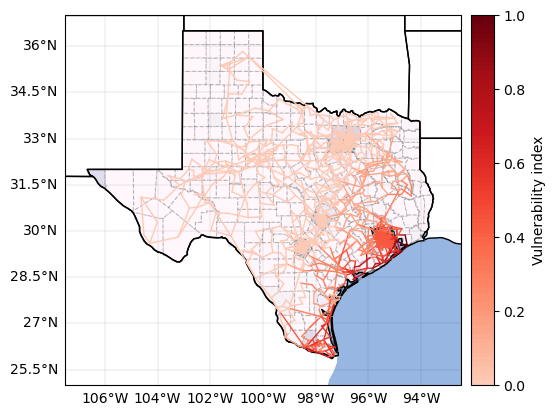

In [9]:
vul_idx = np.loadtxt('vulnerable_lines.csv');

# fig1, ax1 = plt.subplots(figsize=(6, 1))
# fig1.subplots_adjust(bottom=0.5)
# plt.subplot(1, 2, 1)

# cmap = matplotlib.cm.YlOrBr
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

# fig1.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax1, orientation='horizontal', label='Some Units')

# Set the figure size, projection, and extent
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cfeature.LAND, color='white')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.09, color='black', linestyle='--')
gl.top_labels = False
gl.right_labels = False

# loading demographic data
# Load the Texas county shapefile
tx_counties = gpd.read_file('pop_study/County.shp')

# Load the population data
pop_data = pd.read_csv('pop_study/Tx_population.csv', dtype={'CNTY_NM': str, 'census_2020_count': int})
pop_data['census_2020_count'] = pop_data['census_2020_count']/1e5

# Merge the population data with the county shapefile
merged_data = tx_counties.merge(pop_data, on='CNTY_NM')

# plot the demographic data on the county map
merged_data.plot(column='census_2020_count', 
             cmap='PuBu', 
             linewidth=0.8,
             linestyle="--",
             ax=ax, edgecolor=(0, 0, 0, 0.2), 
             legend=False, 
             legend_kwds={'label': "Population by county (in hundred thousand)", 
                          'orientation': "vertical", 'pad': 0.01, 'aspect':16, 'shrink':0.8})

# get color map and normalize
cmap = matplotlib.cm.Reds(np.linspace(0,1,100))
cmap = matplotlib.colors.ListedColormap(cmap[20:,:-1])

# colors for the lines
colors = [cmap(i) for i in np.linspace(0, 1, 256)]

# vulnerability indices
idx = (vul_idx*255).astype(int)


for count in range(len(linedata)):
    plt.plot([linedata['from(X,Y)'][count][0], linedata['to(X,Y)'][count][0]], 
             [linedata['from(X,Y)'][count][1], linedata['to(X,Y)'][count][1]], 
             color=colors[idx[count]], linewidth=1)

    
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical', pad=0.02, aspect=16, shrink=1)
cb.set_label('Vulnerability index', size=10, rotation=90, labelpad=5)
cb.ax.tick_params(labelsize=10)

# Show the plot
plt.show()

# plt.legend(custom_lines, ['115kV', '161kV', '230kV', '500kV'])
# plt.title(hurricane_dataframe['time'][fig_idx].strftime("%Y-%m-%d_%H"))

In [26]:
# create GIF of the list of images

import os
import imageio
from natsort import natsorted

# Set the file names and output file path
png_dir = os.getcwd() # Change to the directory where the PNG files are located
gif_filename = 'hurricane_animation.gif'

# Create a list of all PNG files in the directory
png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]

# Sort the files by filename (assuming the filenames have a numeric sequence)
png_files = natsorted(png_files)

# Create the GIF animation from the PNG files
images = []
for filename in png_files:
    images.append(imageio.imread(os.path.join(png_dir, filename)))
imageio.mimsave(gif_filename, images, duration=0.05)

C:\Users\abodh.poudyal\AppData\Local\Temp\ipykernel_86656\3338599853.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(png_dir, filename)))


### OBTAINING OUTAGE PROBABILITIES OF SUBSTATIONS FROM FLOODING SCENARIOS

In [ ]:
# substation data
sub_data_raw = pd.read_csv(substation_data_filename, sep = '\s+')
sub_lon = sub_data_raw['Longitude'].to_numpy()
sub_lat = sub_data_raw['Latitude'].to_numpy()

sub_per_flood = []

for floods in flood_basins:
    sub_per_flood_dict = {}
    sub_per_flood_dict['basin'] = floods
    
    meow = pd.read_csv(floods + ".csv")
    meow[' Lon'] = -1 * meow[' Lon']

    meow = meow.loc[(meow[' Lon'] <= extent[1]) & (meow[' Lon'] >= extent[0]) & 
                    (meow[' Lat'] <= extent[3]) & (meow[' Lat'] >= extent[2])]
    meow.reset_index()

    Dlat = meow[' Lat']
    Dlon = meow[' Lon']
    sub_flood_idxs_list = []

    for i in range(len(sub_data_raw)):
        sub_flood_idxs = {}

        Olat = sub_data_raw['Latitude'][i]
        Olon = sub_data_raw['Longitude'][i]
        distance_sub = distance_between_two_coordinates(Olon,Olat,Dlat,Dlon,dist="miles")
        meow_indices = distance_sub.index[distance_sub < flood_substation_resolution].tolist()

        if meow_indices:

            meows_values = meow[' Depth'][meow_indices]
            meow_values = meows_values.where(meows_values<99).dropna().tolist()

            if meow_values:
                sub_flood_idxs['sub_idx'] = i 
                sub_flood_idxs['depth'] = round(abs(np.mean(meow_values) - substation_elevation_height), 1)                
                sub_flood_idxs_list.append(sub_flood_idxs)
                
    sub_per_flood_dict['subs_and_depth'] = sub_flood_idxs_list
    sub_per_flood.append(sub_per_flood_dict)

In [ ]:
#################################### OUTAGE PROBABILITY FOR SUBSTATION ####################################################

sub_outage = np.zeros((len(sub_data_raw), len(flood_basins)))

# a,b parameter for fragility
'''
    fragility equation
    np.exp(-1 * (np.array([d['depth'] for d in sub_depth])/a) ** b
    
    b should be odd and use a to stretch or contract the curve
'''
a = weibull_exp_a
b = weibull_exp_b

for flood_num in range(len(sub_per_flood)):

    # list of substation and depth for each flood basin
    sub_depth = sub_per_flood[flood_num]['subs_and_depth']
    sub_outage[[d['sub_idx'] for d in sub_depth], flood_num] = 1 - np.round(np.exp(-1 * (np.array([d['depth'] for d in sub_depth])/a) ** b), 3)

# save substation outage probability
# np.savetxt("substation_outage_abvground.csv", sub_outage, fmt="%1.2f", delimiter=",")

In [ ]:
############################# IDENTIFY THE ACTIVATION TIME INSTANT OF EACH SUBSTATION ##########################################

sub_outage_json_list = []

hurricane_tracks = [0, 1, 2, 4, 9, 10]

# iterate over entire timestamps
for basin_depth_combo in sub_per_flood:  
    
    for tracks in hurricane_tracks:
        
        flood_outage_json = {} 
        
        basin_sub_combo =  deepcopy(basin_depth_combo)  
               
        print("basin = {} and tracks = {}".format(basin_sub_combo['basin'], tracks))
                                                  
        flood_outage_json['track_id'] = tracks
        
        hurricane_dataframe = storm_track.data[tracks].to_dataframe()
        hurricane_dataframe = hurricane_dataframe.reset_index()
        on_land_idx = hurricane_dataframe.index[hurricane_dataframe['on_land']==True].tolist()
        
        flood_outage_json['flood_basin'] = basin_sub_combo['basin']
    
        sub_idx = [d['sub_idx'] for d in basin_sub_combo['subs_and_depth']]
        
        # store the activation flag
        for item in basin_sub_combo['subs_and_depth']: 
            
            # activated flag is 0 for all items
            item['activated'] = 0
            
            # put some high value so that it never gets activated if activated flag = 0
            item['activation_time_idx'] = 9999
    
        for time_stamp in on_land_idx:
        
            # radius of hurricane in particular time stamp
            rs = hurricane_dataframe['radius_oci'][time_stamp]
            
            # x and y coordinates of the eye of the hurricane for each time stamp
            eyeX = hurricane_dataframe['lon'][time_stamp]
            eyeY = hurricane_dataframe['lat'][time_stamp]
            
            # latitude and longitude of substations subject to outage
            Olat = sub_data_raw['Latitude'][sub_idx].to_numpy()
            Olon = sub_data_raw['Longitude'][sub_idx].to_numpy()
            
            # distance between each of those substations from the hurricane eye
            distance_sub = distance_between_two_coordinates(eyeX, eyeY, Olat, Olon, dist="miles")
            
            # the substation is activated for flood if within 95% of the max radius of hurricane
            activation_idx = np.where(distance_sub < 0.95 * rs)[0]
            activated_subs = np.array(sub_idx)[activation_idx]
            
            # store the activated time idx
            for item in basin_sub_combo['subs_and_depth']: 
                if (np.any(activated_subs == item['sub_idx']) & (item['activated'] == 0)):
                    item['activation_time_idx'] = time_stamp
                    item['activated'] = 1
                    
        flood_outage_json['depth_activation'] = basin_sub_combo['subs_and_depth']    
        
        sub_outage_json_list.append(flood_outage_json)

In [ ]:
with open('substation_activation_abvground.json', 'w') as json_file:
    json.dump(sub_outage_json_list, json_file, sort_keys = True, ensure_ascii=False)